The dataset for this project was collected from kaggle and originates from Mendeley Data: The Impact of Covid-19 Pandemic on the Global Economy: Emphasis on Poverty Alleviation and Economic Growth. The data I investigate here consists of records on the impact of covid-19 on the global economy including 210 countries.

Main objective of the analysis is to focus on prediction. In this project, we will employ linear regression algorithms to find relationship between common GDP and human development index and total number of death. We will then choose the best candidate algorithm from preliminary results. The goal with this implementation is to construct a model that accurately predicts how the global economy of each country is affected.


In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV, ElasticNetCV 
from sklearn.pipeline import Pipeline

# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')

data = pd.read_excel('data.xlsx')
data = data.rename(columns={'human_development_index':'hdi'})
data.head()

,iso_code,location,date,total_cases,total_deaths,stringency_index,population,gdp_per_capita,hdi,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,AFG,Afghanistan,2019-12-31,0.0,0.0,0.0,38928341,1803.987,0.498,NaN,NaN,NaN,17.477233,7.497754
1,AFG,Afghanistan,2020-01-01,0.0,0.0,0.0,38928341,1803.987,0.498,NaN,NaN,NaN,17.477233,7.497754
2,AFG,Afghanistan,2020-01-02,0.0,0.0,0.0,38928341,1803.987,0.498,NaN,NaN,NaN,17.477233,7.497754
3,AFG,Afghanistan,2020-01-03,0.0,0.0,0.0,38928341,1803.987,0.498,NaN,NaN,NaN,17.477233,7.497754
4,AFG,Afghanistan,2020-01-04,0.0,0.0,0.0,38928341,1803.987,0.498,NaN,NaN,NaN,17.477233,7.497754


In [ ]:
print('The total number of records: '+str(len(data.index)))
print('Column names: '+str(data.columns.tolist()))
print('Number of countries: '+str(len(data['location'].unique())))
print('Number of missing values: \n' + str(data.isnull().sum()))

The total number of records: 50418
Column names: ['iso_code', 'location', 'date', 'total_cases', 'total_deaths', 'stringency_index', 'population', 'gdp_per_capita', 'hdi', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']
Number of countries: 210
Number of missing values: 
iso_code                0
location                0
date                    0
total_cases          3094
total_deaths        11190
stringency_index     7126
population              0
gdp_per_capita       5712
hdi                  6202
Unnamed: 9           3594
Unnamed: 10         12298
Unnamed: 11         10042
Unnamed: 12             0
Unnamed: 13          5712
dtype: int64


In [ ]:
data = data.drop(['iso_code', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'], axis = 1)
data = data.dropna(axis = 0)
data.isnull().sum()

location            0
date                0
total_cases         0
total_deaths        0
stringency_index    0
population          0
gdp_per_capita      0
hdi                 0
dtype: int64


Let's look at the correlation coefficient. A coefficient close to 1 means that there’s a very strong positive correlation between the two variables. The diagonal line is the correlation of the variables to themselves, that's why they are 1.

In our case we can quickly see that: The Human Development Index (HDI) is strongly correlated to the GDP per Capita and total number case to deaths. The population also has a strong correlation to the number of total cases and deaths. This is what we expected. A high population will have a higher number of cases and deaths. What we are looking for is the relationship between GDP per capita(or HDI) and total number of cases or deaths.

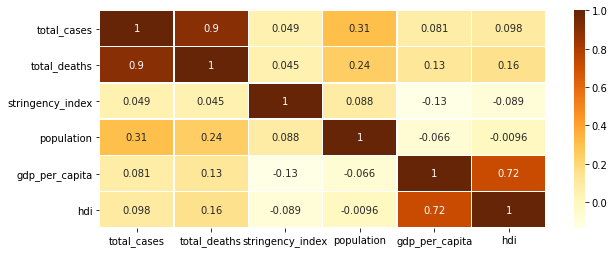

In [ ]:
corr = data.corr(method='pearson')
fig = plt.subplots(figsize = (10, 4))
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='YlOrBr',
            annot=True,
            linewidth=0.5)

In [ ]:
# Log-transform the skewed features
gdp_transformed = data['gdp_per_capita'].apply(lambda x: np.log(x + 1))
total_deaths_transformed = data['total_deaths'].apply(lambda x: np.log(x + 1))

Text(0, 0.5, 'Total Number of Deaths')

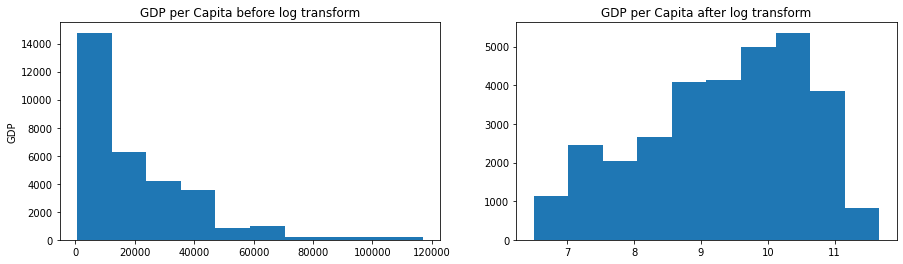

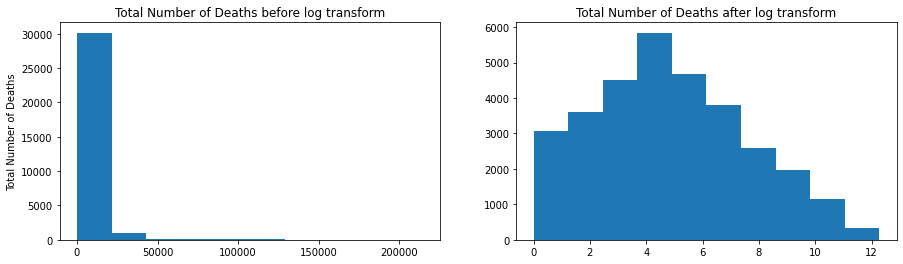

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))

ax1.hist(data['gdp_per_capita'])
ax2.hist(gdp_transformed)
ax1.set_title("GDP per Capita before log transform")
ax2.set_title("GDP per Capita after log transform")
ax1.set_ylabel("GDP")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))

ax1.hist(data['total_deaths'])
ax2.hist(total_deaths_transformed)
ax1.set_title("Total Number of Deaths before log transform")
ax2.set_title("Total Number of Deaths after log transform")
ax1.set_ylabel("Total Number of Deaths")

In [ ]:
data['gdp_per_capita'] = gdp_transformed 
data['total_deaths'] = total_deaths_transformed
data.head()

,location,date,total_cases,total_deaths,stringency_index,population,gdp_per_capita,hdi
0,Afghanistan,2019-12-31,0.0,0.0,0.0,38928341,7.498309,0.498
1,Afghanistan,2020-01-01,0.0,0.0,0.0,38928341,7.498309,0.498
2,Afghanistan,2020-01-02,0.0,0.0,0.0,38928341,7.498309,0.498
3,Afghanistan,2020-01-03,0.0,0.0,0.0,38928341,7.498309,0.498
4,Afghanistan,2020-01-04,0.0,0.0,0.0,38928341,7.498309,0.498


In [ ]:
scaler = MinMaxScaler()
numerical = ['total_deaths', 'gdp_per_capita']
features_log_minmax_transform = pd.DataFrame(data = data)
features_log_minmax_transform[numerical] = scaler.fit_transform(data[numerical])
features_log_minmax_transform

,location,date,total_cases,total_deaths,stringency_index,population,gdp_per_capita,hdi
0,Afghanistan,2019-12-31,0.0,0.000000,0.00,38928341,0.193801,0.498
1,Afghanistan,2020-01-01,0.0,0.000000,0.00,38928341,0.193801,0.498
2,Afghanistan,2020-01-02,0.0,0.000000,0.00,38928341,0.193801,0.498
3,Afghanistan,2020-01-03,0.0,0.000000,0.00,38928341,0.193801,0.498
4,Afghanistan,2020-01-04,0.0,0.000000,0.00,38928341,0.193801,0.498
...,...,...,...,...,...,...,...,...
50413,Zimbabwe,2020-10-15,8055.0,0.443642,76.85,14862927,0.203796,0.535
50414,Zimbabwe,2020-10-16,8075.0,0.443642,76.85,14862927,0.203796,0.535
50415,Zimbabwe,2020-10-17,8099.0,0.443642,76.85,14862927,0.203796,0.535
50416,Zimbabwe,2020-10-18,8110.0,0.443642,76.85,14862927,0.203796,0.535


In [ ]:
from sklearn.model_selection import train_test_split

X_data =  features_log_minmax_transform[['total_cases','total_deaths','stringency_index','population','hdi']]
y_data = features_log_minmax_transform['gdp_per_capita']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 22062 samples.
Testing set has 9456 samples.


In [ ]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)


In [ ]:
# vanilla regression and K-fold cross validation
s = StandardScaler()
lr = LinearRegression()

X_train_s = s.fit_transform(X_train)
lr.fit(X_train_s, y_train)
X_test = s.transform(X_test)  
y_pred = lr.predict(X_test)
score = r2_score(y_test.values, y_pred)

# with pipeline
estimator = Pipeline([("scaler", s),("regression", lr)])
predictions_lr = cross_val_predict(estimator, X_train, y_train, cv=kf)
linear_score = r2_score(y_train, predictions_lr)

linear_score, score #almost identical

(0.7996927742013763, 0.8002741740995301)

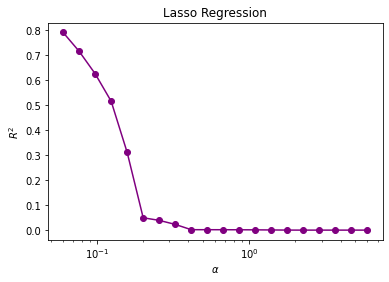

In [ ]:
# lasso regression and K-fold cross validation
s = StandardScaler()
pf = PolynomialFeatures(degree=3)
kf = KFold(shuffle=True, random_state=72018, n_splits=3)
scores = []
alphas = np.geomspace(0.06, 6.0, 20)
predictions_lsr = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions_lsr = cross_val_predict(estimator, X_train, y_train, cv = kf)
    
    score = r2_score(y_train, predictions_lsr)
    
    scores.append(score)
plt.semilogx(alphas, scores, '-o', color='purple')
plt.title('Lasso Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [ ]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X_train, y_train)
lasso_score = best_estimator.score(X_train, y_train)

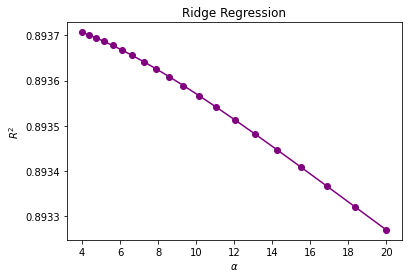

In [ ]:
# ridge regression and K-fold cross validation
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
predictions_rr = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions_rr = cross_val_predict(estimator, X_train, y_train, cv = kf)
    score = r2_score(y_train, predictions_rr)
    scores.append(score)

plt.plot(alphas, scores, '-o', color='purple')
plt.title('Ridge Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [ ]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("ridge_regression", Ridge(alpha=0.03))])

best_estimator.fit(X_train, y_train)
ridge_score = best_estimator.score(X_train, y_train)

In [ ]:
# comparing scores
pd.DataFrame([[linear_score, lasso_score, ridge_score]],columns=['linear', 'lasso', 'ridge'], index=['score'])

,linear,lasso,ridge
score,0.799693,0.834543,0.893962


*Conclusion*: Both Lasso and Ridge with proper hyperparameter tuning give better results than plain Linear Regression!



In [ ]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

# Fit a basic linear regression model
linearRegression = LinearRegression().fit(X_train, y_train)
linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

# Fit a regular (non-cross validated) Ridge model
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
ridgeCV = RidgeCV(alphas=alphas, cv=4).fit(X_train, y_train)
ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

# Fit a Lasso model using cross validation and determine the optimum value for 𝛼
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)
lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

# Fit elastic net with the same set of alphas as lasso
l1_ratios = np.linspace(0.1, 0.9, 9)
elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))


rmse_vals = [linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]

labels = ['Linear', 'Lasso', 'Ridge' 'ElasticNet']

rmse_df = pd.DataFrame([[linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]],columns=['Linear', 'Lasso', 'Ridge', 'ElasticNet'], index=['rmse'])
rmse_df

,Linear,Lasso,Ridge,ElasticNet
rmse,1.397796,1.397007,1.397331,1.397227


[Text(0, 0.5, 'Predicted'),
 Text(0.5, 0, 'Actual'),
 Text(0.5, 1.0, 'Linear Regression Results')]

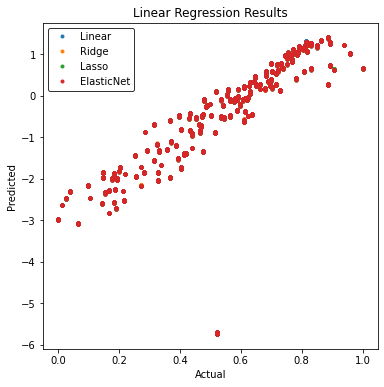

In [ ]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

labels, models = ['Linear', 'Ridge', 'Lasso', 'ElasticNet'], [linearRegression, ridgeCV, lassoCV, elasticNetCV]

for mod, label in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test), marker='o', ls='', ms=3.0, label=label, alpha=1)
    
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual', ylabel='Predicted', title='Linear Regression Results')

Conclusion 2: Lasso gives the smallest Root-mean-square error however, the difference in scores and errors are not significant and almost identical. The best candidate based on Root-mean-square error and score results is Lasso Regression, therefore we recommend LassoCV as a final model that best fits the data in terms of accuracy.

Next Steps
We could further try optimize Lasso using GridSearchCV.

To predict the effect on GDP for an individual country, we could one-hot encode the location or iso_code columns and use that for training our models. Perhaps collecting more frequent records on specific countries would help achieve more accurate results.

And also, We can use neural networks for increase our accuracy.
